In [43]:
#Imports
from math import sqrt, pi, acos, e, atan
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [541]:
#General BEMT Function
def theta(Ctr, r, thetatw, twist_type, solidity, Cla):
    if twist_type == 'ideal':
        theta = (sqrt(Ctr/2) + 4*Ctr/(Cla*solidity))/r
        return theta
    elif twist_type == 'linear':
        theta0 = 6*Ctr/(solidity*Cla) - 0.75*thetatw + 1.5*sqrt(Ctr/2)
        return theta0
    
def BEMT(prandtl, solidity_e, Ctr, twist_type, thetatw, Nb, Cld, taper, RC):
    if twist_type == 'linear':
        if prandtl == 'no':
            #add the F additions
            lambdalist = np.zeros(N)
            flamb = np.zeros(N)
            dCt = np.zeros(N)
            dCpind = np.zeros(N)
            dCpprof = np.zeros(N)
            Cljlist = np.zeros(N)
            Cdjlist = np.zeros(N)
            dCq = np.zeros(N)
            r = np.zeros(N)
            tol = 1
            F = 1
            ri = 0
            Cla = 2*pi
            theta0j = theta(Ctr, ri, thetatw, twist_type, solidity_e, Cla)
            iterat = 0
            while tol > .001:
                for j in range(N):
                    tol2 = 1
                    rj = (j*dr)+(0.5*dr+RC)
                    Vj = rj*omega*.041
                    Re = (rho*Vj*L)/mu
                    sol1 = 4*solidity_e*((1-taper)/(taper+3))
                    solidity = solidity_e + sol1*(rj - 3/4)
                    r[j] = rj
                    thetaj = theta0j + thetatw*rj
                    lambdaguess = 0
                    iterat2 = 0
                    while tol2 > nacatol:
                        alpha = thetaj - atan(lambdaguess/rj)
                        Clj, Cdj = Cld(Re, alpha*180/pi)
                        Clj = abs(Clj)
                        Cla = Clj/alpha
                        lambdaguess = (solidity*Cla)/(16*F)*(sqrt(1+(32*F*thetaj*rj)/(solidity*Cla))-1)
                        flamb[j] = .5*solidity*Clj*rj**2 - 4*lambdaguess**2*rj
                        tol2 = abs(flamb[j])
                        if iterat2 > 20 and abs(lambdaguess-oldl) < .005 and NACA == '6504':
                            lambdaguess = (lambdaguess + oldl)/2
                            Clj = (Clj + oldClj)/2
                            Cla = (Cla + oldCla)/2
                            break
                        iterat2 += 1
                        oldl = lambdaguess
                        oldClj = Clj
                        oldCla = Cla
                    Cljlist[j] = Clj
                    Cdjlist[j] = Cdj
                    dCtj = .5 * solidity * abs(Clj) * rj**2 * dr
                    dCpindj = lambdaguess * dCtj
                    dCpprofj = .5 * solidity * Cdj * rj**3 * dr
                    lambdalist[j] = lambdaguess
                    dCt[j] = dCtj
                    dCpind[j] = dCpindj
                    dCpprof[j] = dCpprofj
                    dCq[j] = dCpindj + dCpprofj
                CTj = sum(dCt)
                CPj = sum(dCpind) + sum(dCpprof)
                theta0j += 6*(Ctr-CTj)/(solidity_e*Cla)+3/4*sqrt(2)*(sqrt(Ctr)-sqrt(abs(CTj)))
                tol = abs(Ctr-CTj)/Ctr
                if iterat > 20 and abs((CTj + CT)/2 - Ctr) < .001:
                    CT = (CTj + CT)/2
                    CP = (CPj + CP)/2
                    break
                CT = sum(dCt)
                CP = sum(dCpind) + sum(dCpprof)
                iterat += 1
            return lambdalist, dCt, dCpind, dCpprof, CT, CP, dCq, Cljlist, Cdjlist, r, thetaj
        else:
            print('Please enter no for Prandtl!')
            return
    else:
        print('Please enter linear for twist_type!')
        return

In [462]:
def Cld(Re, alpha):
    if NACA == '0012':
        folderstring = 'NACA0012'
        if Re < 15e3:
            string = '10e3_M0.1_DT0.1.txt'
        elif Re >= 15e3 and Re < 25e3:
            string = '20e3_M0.1_SA.txt'
        elif Re >= 25e3 and Re < 35e3:
            string = '30e3_M0.1_DT0.1.txt'
        elif Re >= 35e3 and Re < 45e3:
            string = '40e3_M0.1_DT0.1.txt'
        elif Re >= 45e3 and Re < 85e3:
            string = '60e3_M0.1_DT0.1.txt'
        elif Re >= 75e3:
            string = '100e3_M0.1_DT0.1.txt'
    elif NACA == '6504':
        folderstring = 'NACA6504'
        if Re < 30e3:
            string = '20e3_M0.1_DT0.1.txt'
        elif Re >= 30e3 and Re < 50e3:
            string = '40e3_M0.1_DT0.1.txt'
        elif Re >= 50e3 and Re < 80e3:
            string = '60e3_M0.1_DT0.1.txt'
        elif Re >= 80e3:
            string = '100e3_M0.1_DT0.1.txt'
    else:
        print('Please enter 0012 or 6504 for NACA!')
    
    data_folder = Path('C:/Users/Connor/OneDrive/Documents/School/College/Fourth Year/Fall 2023/Aero 655/Project')
    folder_to_open = data_folder / folderstring
    file_to_open = folder_to_open / string
        
    gen = (float(line.partition(' ')[0]) for line in open(file_to_open))
    key = (min(enumerate(gen), key=lambda x: abs(x[1] - alpha)))[0]
    
    with open(file_to_open, 'r') as file:
        content = file.readlines()
        line = content[key]
        values = line.split('  ')
        Cl = float(values[1])
        valuesd = values[2].split(' ')
        Cd = float(valuesd[0])

    return Cl, Cd

In [564]:
NACA = '0012'
rho = 1.173
mu = 1.846e-5
omega = 10000*2*pi/60
Nb = 2
twist_type = 'linear'
thetatw = 0
taper = 1
solidity_e = .17
Ctr = [.0163, .0143, .0117, .0095, .0071]
prandtl = 'no'
N = 100
RC = .02439
dr = (1-RC)/N
L = .011

nacatol = .01
CTlist = []
CPlist = []
print('NACA-0012:')
for i in range(len(Ctr)):
    vals = BEMT(prandtl, solidity_e, Ctr[i], twist_type, thetatw, Nb, Cld, taper, RC)
    CTlist.append(vals[4])
    CPlist.append(vals[5])
    print('CT:', vals[4], ' CP:', vals[5])
    
print('\n')
truevalsx = Ctr
truevalsy = [.0033, .0026, .0019, .0016, .0012]


NACA = '6504'
nacatol = .0001
Ctr = [.0276, .0245, .0216, .0196, .0172, .0137]

CTlist2 = []
CPlist2 = []
print('NACA-6504:')
for i in range(len(Ctr)):
    vals = BEMT(prandtl, solidity_e, Ctr[i], twist_type, thetatw, Nb, Cld, taper, RC)
    CTlist2.append(vals[4])
    CPlist2.append(vals[5])
    print('CT:', vals[4], ' CP:', vals[5])
    
truevalsx2 = Ctr
truevalsy2 = [.0058, .0048, .0039, .0034, .0028, .0022]

NACA-0012:
CT: 0.01607978963439022  CP: 0.003117061029180824
CT: 0.014279239635166693  CP: 0.0024632670824749495
CT: 0.011693729037519512  CP: 0.0017315463214009797
CT: 0.009433039758319394  CP: 0.0015423408250118706
CT: 0.007860544439724362  CP: 0.0012908244297891874


NACA-6504:
CT: 0.027602043785995664  CP: 0.005593678380253348
CT: 0.024491306243736837  CP: 0.004420882558462444
CT: 0.021598688668511414  CP: 0.00358927943620324
CT: 0.019617138212520566  CP: 0.003122928325741915
CT: 0.017199108908295197  CP: 0.002625002598268586
CT: 0.013697187082161071  CP: 0.001999019210482093


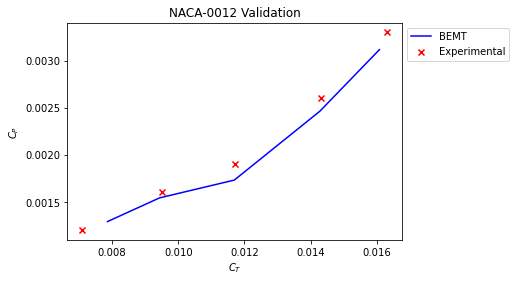

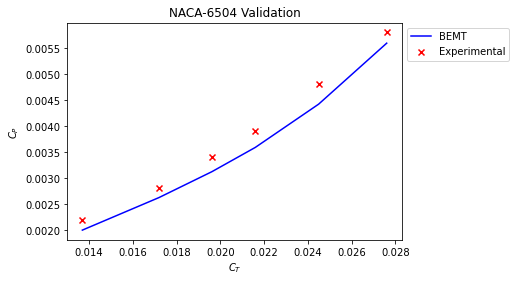

In [568]:
plt.scatter(truevalsx,truevalsy, color = 'red', marker = 'x', label = 'Experimental')
plt.plot(CTlist,CPlist, color = 'blue', label = 'BEMT')
plt.title('NACA-0012 Validation')
plt.xlabel('$C_T$')
plt.ylabel('$C_P$')
plt.legend(bbox_to_anchor = (1,1))

plt.figure()
plt.scatter(truevalsx2,truevalsy2, color = 'red', marker = 'x', label = 'Experimental')
plt.plot(CTlist2,CPlist2, color = 'blue', label = 'BEMT')
plt.title('NACA-6504 Validation')
plt.xlabel('$C_T$')
plt.ylabel('$C_P$')
plt.legend(bbox_to_anchor = (1,1))

In [570]:
solidity = 0.175
Ctr = np.linspace(.01, .03, 10)
NACA = '6504'

thetas = np.zeros((len(Ctr),1))
CT = np.zeros((len(Ctr),1))
CP = np.zeros((len(Ctr),1))
FM = np.zeros((len(Ctr),1))
for i in range(len(Ctr)):
    vals = BEMT(prandtl, solidity, Ctr[i], twist_type, thetatw, Nb, Cld, taper, RC)
    CT[i] = vals[4]
    CP[i] = vals[5]
    thetas[i] = vals[10]
    FM[i] = CT[i]**(3/2)/sqrt(2)/CP[i]

Max FM: 0.6290197621889987
Corresponding Blade Pitch Angle: 13.114457392215787
Corresponding Thrust Coefficient: 0.021113081488589886


Text(0, 0.5, 'FM')

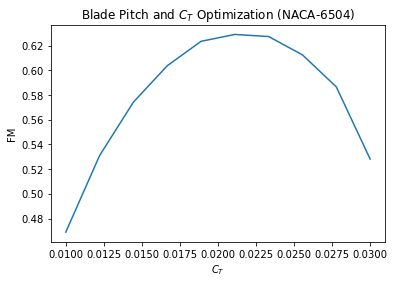

In [573]:
plt.plot(Ctr, FM)
print('Max FM:', FM[5][0])
print('Corresponding Blade Pitch Angle:',thetas[5][0]*180/pi)
print('Corresponding Thrust Coefficient:', CT[5][0])
plt.title('Blade Pitch and $C_T$ Optimization (NACA-6504)')
plt.xlabel('$C_T$')
plt.ylabel('FM')

In [561]:
Ctr = .0211
solidity = .175
l = 10
    
thetatwglobal_cont = np.linspace(-1*40*pi/180,-1*10*pi/180,l)
taper_cont = np.linspace(1,50,l)

CP5_cont = np.zeros((len(taper_cont),len(thetatwglobal_cont)))
CT5_cont = np.zeros((len(taper_cont),len(thetatwglobal_cont)))
FM_cont = np.zeros((len(taper_cont),len(thetatwglobal_cont)))

for i in range(len(taper_cont)):
    for j in range(len(thetatwglobal_cont)):
        CT5_cont[i][j], CP5_cont[i][j] = (BEMT(prandtl, solidity, Ctr, twist_type, thetatwglobal_cont[j], Nb, Cld, taper_cont[i], RC))[4:6]
        FM_cont[i][j] = CT5_cont[i][j]**(3/2)/sqrt(2)/CP5_cont[i][j]

Text(0.5, 1.0, 'Optimal Blade Twist and Taper Combination (Low Resolution)')

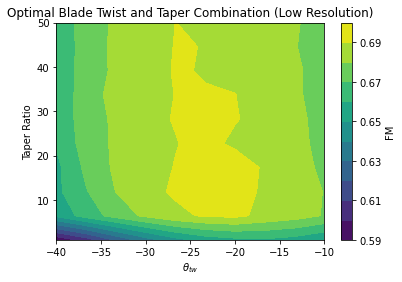

In [562]:
fig, ax = plt.subplots()
plt.contourf(thetatwglobal_cont*180/pi, taper_cont, FM_cont, 10)
cbar = plt.colorbar()
cbar.ax.set_ylabel('FM')
plt.xlabel('$\\theta_{tw}$')
plt.ylabel('Taper Ratio')
plt.title('Optimal Blade Twist and Taper Combination (Low Resolution)')

Text(0.5, 1.0, 'Optimal Blade Twist and Taper Combination (High Resolution)')

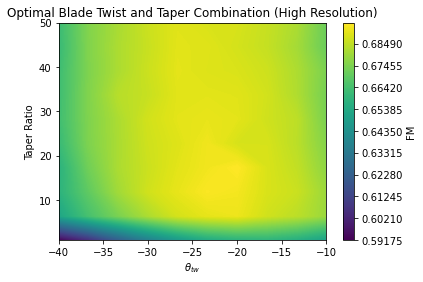

In [563]:
fig, ax = plt.subplots()
plt.contourf(thetatwglobal_cont*180/pi, taper_cont, FM_cont, 1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel('FM')
plt.xlabel('$\\theta_{tw}$')
plt.ylabel('Taper Ratio')
plt.title('Optimal Blade Twist and Taper Combination (High Resolution)')